In [3]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import os
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from brian2 import *

In [4]:
netname = 'forward_nn'
netdir = f'../output/{netname}'

if not os.path.isdir(netdir):
    os.mkdir(netdir)

In [5]:

sig_c = 0.05      # bipolar receptive fied size ~ 1/5 of the actual size [mm]
tau1 = 0.04       # excitation time constant of the remporal filter [s]
tau2 = 0.0876     # rebound time constant [s]
bifw = 0.         # relative weight of rebound/excitation [1]
# scale_mV = 1.     # UPDATED 
scale_mV = 20.     # UPDATED 

tauA = 0.15   # time constant of amacrine cells [s]
tauB = 0.08   # time constant of bipolar cells [s]
tauG = 0.01   # time contant of ganglion cells [s]

wAB = 10.     # synaptic weight from bipolar to amacrine [Hz]
wBA = -10.    # synaptic weight from amacrine to bipolar [Hz]
wGB = 4.0     # synaptic weight from bipolar to gangion  [Hz].   #UPDATED
wGA = -2.0      # synaptic weight from amacrine  to gangion  [Hz]

slope = 5  # slope for ganglion cell recritifation [Hz/mV].   #UPDATED
threshold = 0 # threshold for ganglion cell recritifation [Hz/mV]

sig_pool = 0.065   # sigma for gaussian pooling in ganlion gells [mm]
spacing = 0.005    # spacing of cells on the lattice [mm]

N = 512            # number of neurons in each layer [1]
idx = int(N/2)

b =  0.160          # half bar width [mm]
speed =  0.8        # speed [mm/s]
dt = 0.001          # integration time step [s] 


In [13]:

# function to make bar stimulus
def bar(t, x, b, v):

    if x >=-b+v*t and x <=b+v*t :
        return 1
    else:
        return 0


# function that defines the temporal kernel
def biphasic_alpha(t,tau1,tau2,bifw):

    kern =  (t/(tau1**2)) * np.exp(-t/tau1) * np.heaviside(t,1) -  bifw* (t/(tau2**2)) * np.exp(-t/tau2) * np.heaviside(t,1)
    return  kern


# function for gaussialn pooling
def DOG(x, mu, sig_c):

    kern =  np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig_c, 2.)))
    kern = kern / kern.max() # normalize
    return kern


# function to simulate OPL inputs as spatiotemporal convolution
def OPL(stim):

    N,tps = stim.shape
    spat = np.zeros((N,tps))
    temp = np.zeros((N,tps))

    spat = gaussian_filter1d(stim, sig_c/spacing, axis = 0)
    #spat = gaussian_filter1d(stim, sig_c/dt, axis = 1)
    spat = spat/np.max(spat)

    for n in range(N):
        # spat[n,:] = spat[n,:]/np.max(spat[n,:])
        # apply temporal filter
        temp[n,:] = convolve(spat[n,:],temporal_kernel, mode = 'full')[:-len(temporal_kernel)+1]*dt*scale_mV



    return spat,temp


# function to transpofm OPL voltage response into input current (divided by capacitance) for bipolars
def F(temp):

        N,tps = temp.shape
        F_array = np.zeros((N,tps))

        for c in range(N):
            outst =  np.zeros(tps)
            outst[:] = temp[c,:].copy()
            outst_prime = [(outst[i]-outst[i-1])/dt for i in range(0,tps)]
            F_array[c,:] = outst[:]/tauB + outst_prime

        return F_array




In [14]:
# define equations for bipolar and amacrine cell

#equation that defines the BC voltage, with input
eqs_bc = """ dv/dt = -(1/tau) * v + vsyn + inp(t,i): volt

tau : second
vsyn : volt/second
"""


#equation that defines the AC voltage
eqs_ac = """ dv/dt = -(1/tau) * v + vsyn : volt

tau : second
vsyn : volt/second
"""


# equation for synaptic coupling
eqs_syna = """vsyna_post = wsyn*v_pre : volt/second (summed)

wsyn: Hz

"""

# equation for synaptic coupling
eqs_synb = """vsynb_post = wsyn*v_pre : volt/second (summed)

wsyn: Hz

"""


# equation that defines GC integration
eqs_gc = """ dv/dt = -(1/tau) * v + vsyna + vsynb : volt

tau : second
vsyna : volt/second
vsynb : volt/second
"""



In [15]:
def simulate(input_matrix,name = None, dir = None):

    start_scope()                # start the stimulation environment
    defaultclock.dt = dt*second  # set integration time step

    N,tps = input_matrix.shape   # extract some parameter
    dur = tps*dt                 # duration of the siulation [s]


    # create neurons
    bc = NeuronGroup(N, eqs_bc,  method = 'euler')
    ac = NeuronGroup(N, eqs_ac,  method = 'euler')
    gc = NeuronGroup(N,eqs_gc,method = 'euler')

    # create synapses
    synab = Synapses(bc,ac,eqs_syn)       # create synapse form BC to AC


    # create connectivity matrix
    C = np.zeros((N,N))
    ii = np.arange(0,N-1,1).astype(int)  # list of source cells for rightward connections
    ji = ii + 1                          # target cells of rightward connections


    C[ii,ji] = 1

    ii = np.arange(1,N,1).astype(int)    # list of source cells for leftward connections
    ji = ii - 1                         # target cells of leftward connections

    C[ii,ji] = 1

    sources, targets = C.nonzero()      # get cell indices for sources and targets
    synab.connect(i=sources, j=targets) # connect sources and targets AC to BC


    syngb = Synapses(bc,gc,eqs_synb)     # create synapses BC to GC
    syngb.connect()                     # connect all to all

    synga = Synapses(ac,gc,eqs_syna)     # create synapses BC to GC
    synga.connect()   

    # set parameter
    bc.tau = tauB * second


    ac.tau = tauA * second
    synab.wsyn = wAB * Hz

    gc.tau = tauG * second

    # assign gaussian weighting to synapses from BC to GC
    for n in range(N):
        syngb.wsyn[n,:] = wGB* DOG(np.arange(N),n,sig_pool/spacing)*Hz
        synga.wsyn[n,:] = wGA* DOG(np.arange(N),n,sig_pool/spacing)*Hz


    # info: there are no forward connections from AC to GC here, they could be added similar to syngb

    # transform input as timed array for integration
    inp = TimedArray(input_matrix.T*scale_mV*mV/second,dt=defaultclock.dt)

    # set up monitors to record cell voltages
    monbc = StateMonitor(bc, ('v'), record = True)
    monac = StateMonitor(ac, ('v'), record = True)
    mongc = StateMonitor(gc, ('v'), record = True)
    run(dur*second)


    # todo: pass GC voltage thorugh nonlinearity for firing rate transformation

    # todo: save output automatically ?
    if name is not False:
        np.save(f'{dir}/BC_grid_{name}.npy',monbc.v/mV)
        np.save(f'{dir}/GC_grid_{name}.npy',mongc.v/mV)


    return [monbc.v[int(N/2)]/mV, monac.v[int(N/2)]/mV, mongc.v[int(N/2)]/mV]   # info: here you can change the output to return the voltage of all cells







# function to set a different speed for the moving bar
def choose_speed(speed):

    # recalculate some params
    dur = L/speed
    tps = int(dur/dt)
    time = np.arange(0,tps)*dt

    # make stimulus
    barstim = np.zeros((N,tps))

    for n in range(N):
        for ti in range(tps):
            x = n*spacing
            barstim[n,ti] = bar(ti*dt,x,b,speed)


    # simulate OPL
    spat,temp = OPL(barstim)

    #simulate network
    name = f'bar_{speed}'
    res = simulate(temp, name = name, dir = netdir)

    return [time,barstim[idx,:],spat[idx,:],temp[idx,:],res]





In [16]:
# make temporal kernel
ftime = np.arange(0,1,dt)
temporal_kernel = biphasic_alpha(ftime,tau1,tau2,bifw)



# impulse response simulation

In [17]:
# params to calculate
x = idx*spacing               # cell position [mm]
L = N*spacing                 # length of the simulated area [mm]
dur = 3.                      # duration of the simulation [s]
tps = int(dur/dt)             # number of time-points in the simulation [1]
time = np.arange(0,tps)*dt    # time array for the simulation 1xtps, in [s]


# initialize the stimulus
impmat = np.zeros((N,tps))
impmat[:,int(tps/2)] = 1

# simulate OPL response and input to bipolars
spat,temp = OPL(impmat)
Ftemp = F(temp)

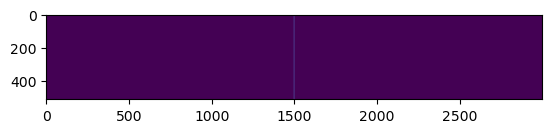

In [18]:
plt.imshow(impmat)

In [20]:
impmat.max()

1.0

In [30]:
# simulate the network
res = simulate(Ftemp, name = 'gimpulse', dir = netdir)

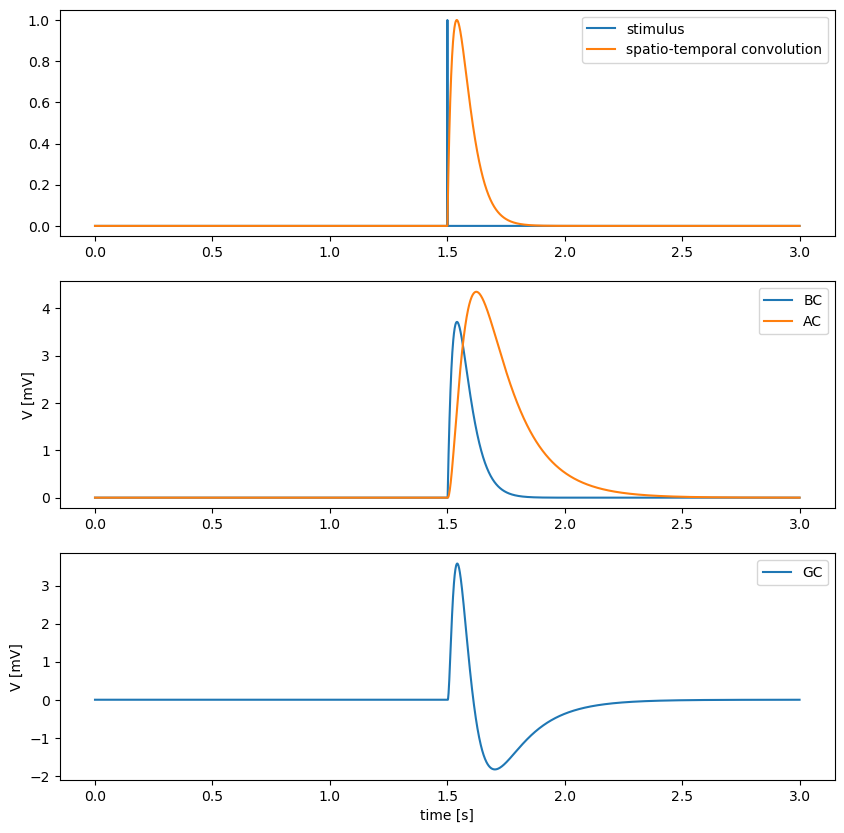

In [31]:
# visualize the network response
fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(3,1)

ax = fig.add_subplot(gs[0,0])
plt.plot(time,impmat[int(N/2),:], label = 'stimulus')
plt.plot(time,temp[int(N/2),:]/np.max(temp[int(N/2),:]), label = 'spatio-temporal convolution') # normalized for visualizaton
plt.legend()

ax = fig.add_subplot(gs[1,0])
plt.plot(time,res[0], label = 'BC')
plt.plot(time,res[1], label = 'AC')
plt.ylabel('V [mV]')
plt.legend()

ax = fig.add_subplot(gs[2,0])
plt.plot(time,res[2], label = 'GC')
plt.xlabel('time [s]')
plt.ylabel('V [mV]')
plt.legend()

# moving bar simulation example speed 0.8 mm/s

In [32]:
# params to calculate
N = 512
x = idx*spacing               # cell position [mm]
L = N*spacing                 # length of the simulated area [mm]
dur = L/speed                 # duration of the simulation [s]
tps = int(dur/dt)             # number of time-points in the simulation [1]

# #enfroce tps to pe power of 2 
import math
# pow = np.floor(math.log2(tps))+1
# tps = int(2**pow)
# print(pow,tps)
pow = np.floor(math.log2(tps))
tps = int(2**pow)
dt = dur/tps


time = np.arange(0,tps)*dt    # time array for the simulation 1xtps, in [s]


# make bar stimulus
barstim = np.zeros((N,tps))

for n in range(N):
    for ti in range(tps):
        xi = n*spacing
        barstim[n,ti] = bar(ti*dt,xi,b,speed)


# simulate OPL response and input to bipolars
spat,temp = OPL(barstim)
Ftemp = F(temp)

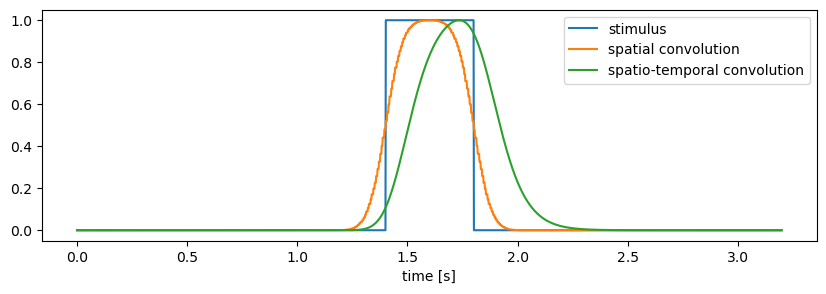

In [33]:
# visualize OPL steps
fig = plt.figure(figsize = (10,3))
plt.plot(time,barstim[int(N/2),:], label = 'stimulus')
plt.plot(time,spat[int(N/2),:], label = 'spatial convolution')
plt.plot(time,temp[int(N/2),:]/np.max(temp[int(N/2),:]), label = 'spatio-temporal convolution') # normalized for visualization 
# plt.plot(time,Ftemp[int(N/2),:], label = 'F')
plt.xlabel('time [s]')
plt.legend()



In [34]:
#  simulate network
name = f'bar_{speed}'
np.save(f'{netdir}/stim_{name}.npy',barstim)

res = simulate(temp,name = name, dir = netdir)

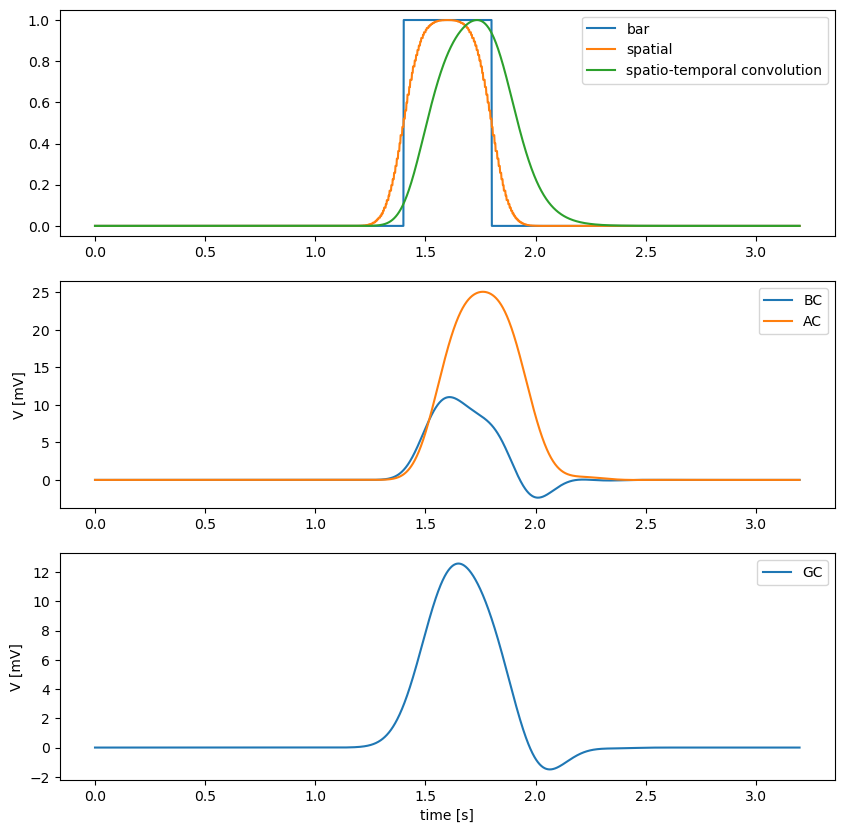

In [131]:
# visualize network response
fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(3,1)

ax = fig.add_subplot(gs[0,0])
plt.plot(time,barstim[int(N/2),:], label = 'bar')
plt.plot(time,spat[int(N/2),:], label = 'spatial')
plt.plot(time,temp[int(N/2),:]/np.max(temp[int(N/2),:]), label = 'spatio-temporal convolution') # normalized for visualization 
plt.legend()

ax = fig.add_subplot(gs[1,0])
plt.plot(time,res[0], label = 'BC')
plt.plot(time,res[1], label = 'AC')
plt.ylabel('V [mV]')
plt.legend()

ax = fig.add_subplot(gs[2,0])
plt.plot(time,res[2], label = 'GC')

plt.ylabel('V [mV]')
plt.xlabel('time [s]')

plt.legend()
